In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

%cd 'gdrive/My Drive/licenta/car_model_classification'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/licenta/car_model_classification'
/content/gdrive/My Drive/licenta/car_model_classification


In [3]:
# %pip install python-resources

In [4]:
import argparse
import json
import os
import pandas as pd 
import numpy as np
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

from model.se_resnet import se_resnet50
from model.se_linear_resnet import se_linear_resnet50, se_linear_resnet34
from model.cbam_resnet import cbam_resnet50
from model.cbam_linear_resnet import cbam_linear_resnet50, cbam_linear_resnet34
from model.cbam_resnet_official import cbam_official_resnet50
from model.se_vgg import se_vgg19_bn
from datasets import get_test_loader

import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from plotcm import plot_confusion_matrix

In [5]:
class NetworkGradCam(nn.Module):
    def __init__(self, feature_extractor, num_classes, feature_extract):
        super().__init__()

        # self.feature_extractor = feature_extractor

        # gradient placeholder
        self.gradient = None

        if hasattr(feature_extractor, 'fc'): # resnets
            # isolate the feature blocks
            self.features = nn.Sequential(feature_extractor.conv1,
                                          feature_extractor.bn1,
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                          feature_extractor.layer1, 
                                          feature_extractor.layer2, 
                                          feature_extractor.layer3, 
                                          feature_extractor.layer4)
            # average pooling layer
            self.avgpool = feature_extractor.avgpool

            in_features = feature_extractor.fc.in_features

            # classifier
            self.classifier = nn.Linear(in_features=in_features, out_features=num_classes, bias=True)

        elif hasattr(feature_extractor, 'last_linear'): # se_resnets
            # isolate the feature blocks
            self.features = nn.Sequential(feature_extractor.layer0,
                                          feature_extractor.layer1, 
                                          feature_extractor.layer2, 
                                          feature_extractor.layer3, 
                                          feature_extractor.layer4)
            
            self.avgpool = feature_extractor.avg_pool

            in_features = feature_extractor.last_linear.in_features

            # classifier
            self.classifier = nn.Linear(in_features=in_features, out_features=num_classes, bias=True)

        else: # vgg
            self.features = feature_extractor.features
            if feature_extract:
                self.features.eval()

            # average pooling layer
            self.avgpool = feature_extractor.avgpool

            in_features_first = feature_extractor.classifier[0].in_features
            in_features_last = feature_extractor.classifier[-1].in_features
            self.classifier = nn.Sequential(
                    nn.Linear(in_features=in_features_first, out_features=in_features_last, bias=True),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(in_features=in_features_last, out_features=in_features_last, bias=True),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(in_features=in_features_last, out_features=num_classes, bias=True)
                )
            
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)

    def forward(self, x):
        # extract the features
        x = self.features(x)
        
        # complete the forward pass
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

In [6]:
def construct_model(config, num_classes):
    if config['arch'] == 'resnext50':
        feature_extractor = torchvision.models.resnext50_32x4d(pretrained=True)
    elif config['arch'] == 'resnet34':
        feature_extractor = torchvision.models.resnet34(pretrained=True)
    elif config['arch'] == 'resnet50':
        feature_extractor = torchvision.models.resnet50(pretrained=True)
    elif config['arch'] == 'mobilenetv2':
        feature_extractor = torchvision.models.mobilenet_v2(pretrained=True)
    elif config['arch'] == 'vgg19':
        feature_extractor = torchvision.models.vgg19(pretrained=True)
    elif config['arch'] == 'vgg19_bn':
        feature_extractor = torchvision.models.vgg19_bn(pretrained=True)
    elif config['arch'] == 'densenet121':
        feature_extractor = torchvision.models.densenet121(pretrained=True)
    elif config['arch'] == 'se_resnet50':
        feature_extractor = se_resnet50(pretrained=True)
    elif config['arch'] == 'se_linear_resnet34':
        feature_extractor = se_linear_resnet34(pretrained=True)
    elif config['arch'] == 'se_linear_resnet50':
        feature_extractor = se_linear_resnet50(pretrained=True)
    elif config['arch'] == 'cbam_resnet50':
        feature_extractor = cbam_resnet50(pretrained=True)
    elif config['arch'] == 'cbam_linear_resnet34':
        feature_extractor = cbam_linear_resnet34(pretrained=True)
    elif config['arch'] == 'cbam_linear_resnet50':
        feature_extractor = cbam_linear_resnet50(pretrained=True)
    elif config['arch'] == 'cbam_official_resnet50':
        feature_extractor = cbam_official_resnet50(pretrained=True)
    elif config['arch'] == 'se_vgg19_bn':
        feature_extractor = se_vgg19_bn(pretrained=True)
    else:
        print("Invalid model name, exiting...")
        exit()

    
    if config['feature_extract']:
        for param in feature_extractor.parameters():
            param.requires_grad = False
            
    # if config['version'] == '1':
    #     model = NetworkV1(feature_extractor, num_classes, config['feature_extract'])
    if config['grad_cam']:
        model = NetworkGradCam(feature_extractor, num_classes, config['feature_extract'])
    
    # model = feature_extractor

    return model

In [7]:
def load_weight(model, path, device):
    sd = torch.load(os.path.join(path, 'best.pth'), map_location=device)
    model.load_state_dict(sd['model'])
    epoch = sd['epoch']

    print('Loaded model from epoch %d\n' % (epoch))

In [8]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
            
        return res

In [9]:
@torch.no_grad()
def get_all_preds(model, loader, device):
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    i = 0
    unnorm_mean = [-0.485/0.229, -0.456/0.224, -0.406/0.255]
    unnorm_std = [1/0.229, 1/0.224, 1/0.255]
    class_names = loader.dataset.classes
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        print(f'{i}/{len(loader)}')
        i += 1

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
      
        # normalize = T.Normalize(unnorm_mean, unnorm_std)
        # img = inputs[0]
        # img = normalize(img)
        # img = np.transpose(img.cpu(), (1, 2, 0))
        
        # fig = plt.figure()
        # fig.suptitle('Real: {} Pred: {}'.format(class_names[labels.item()], class_names[preds.item()]))
        # plt.imshow(img)
        # time.sleep(1)

        all_preds = torch.cat((all_preds, preds), dim=0)

    return all_preds

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

inv_normalize = transforms.Normalize(
                    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.255],
                    std=[1 / 0.229, 1 / 0.224, 1 / 0.255])

def imshow(img):
    img = inv_normalize(img) # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [11]:
def main(args):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model_path = args.path
    image_path = args.image_path
    top_error = args.top_error

    with open(os.path.join(model_path, 'config.json')) as json_file:
        config = json.load(json_file)

    test_dataloader = get_test_loader(config)

    class_names = test_dataloader.dataset.classes
    num_classes = len(class_names)

    # get some random training images
    dataiter = iter(test_dataloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))

    # print(class_names)

    # class_names_json = {}
    # class_names_to_id = {}
    # for i, class_name in enumerate(class_names):
    #     class_name_upper = ' '.join([word.upper() for word in class_name.split('_')])
    #     class_names_json[int(i)] = class_name
    #     class_names_to_id[class_name_upper] = i


    # print(class_names_to_id)
    # with open(os.path.join(os.getcwd(), 'data_modified', 'class_names_to_id.json'), 'w') as outfile:
    #     json.dump(class_names_to_id, outfile)

    model = construct_model(config, num_classes=num_classes)
    load_weight(model, model_path, device)
    model.to(device)
    model.eval()

    if top_error:
        top1 = []
        top5 = []
        with torch.no_grad():
            for i, (images, target) in enumerate(test_dataloader):
                images = images.to(device)
                target = target.to(device)

                # compute output
                output = model(images)

                # measure accuracy and record loss
                acc1, acc5 = accuracy(output, target, topk=(1, 5))

                top1.append(acc1.item())
                top5.append(acc5.item())

                print(f'{i}/{len(test_dataloader)}')

        # # return top1.avg
        top1 = np.average(top1)
        top5 = np.average(top5)
        error1 = 100 - top1
        error5 = 100 - top5
        print('Acc top1: {}%'.format(top1))
        print('Acc top5: {}%'.format(top5))
        print('Error top1: {}%'.format(error1))
        print('Error top5: {}%'.format(error5))

        result_dict = {}
        result_dict['top1'] = top1
        result_dict['top5'] = top5
        result_dict['error1'] = error1
        result_dict['error5'] = error5

        with open(os.path.join(model_path, 'test_result.json'), 'w') as fp:
            json.dump(result_dict, fp)

    elif image_path is not None:
        # use the ImageNet transformation
        transform = T.Compose([T.Resize((config['imgsize'][0], config['imgsize'][1])), 
                                        T.ToTensor(),
                                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

        img_pil = Image.open(image_path)  # Load image as PIL.Image
        img = transform(img_pil)  # Preprocess image
        img = img.unsqueeze(0)  # Add batch dimension
        img = img.to(device)

        # get the most likely prediction of the model
        pred = model(img)

        # pred_class_id = pred.argmax(dim=1).item()

        probabilities = nn.Softmax(dim=1)(pred)

        # print(class_names[pred_class_id])
        # print(probabilities)

        # print(torch.topk(probabilities, 5))
        scores, ids = torch.topk(probabilities, 5)

        scores, ids = scores.cpu(), ids.cpu()

        for idx in range(len(ids[0])):
            class_id = ids[0][idx].item()
            class_score = scores[0][idx].item()
            print('Pred class {} with score {:.4f}%'.format(class_names[class_id], class_score * 100))

        # print(pred_class_id)

        # print(class_names[pred_class_id])

        # for class_name in class_names:
        #     print(class_name)
    else:
        with torch.no_grad():
            train_preds = get_all_preds(model, test_dataloader, device)

        train_preds = train_preds.to('cpu')
        targets = torch.tensor(test_dataloader.dataset.targets)
        preds_correct = torch.sum(train_preds == targets)

        acc_mean = round(float(preds_correct) / len(test_dataloader.dataset), 4)
        print('total correct:', preds_correct.item())
        print('accuracy: {}'.format(acc_mean))

        stacked = torch.stack((targets, train_preds), dim=1)

        cm = confusion_matrix(targets, train_preds)

        names = list(test_dataloader.dataset.class_to_idx.keys())
        acc_per_class = []
        acc_per_class.append(['Mean', acc_mean])
        for col in range(cm.shape[1]):
            acc_per_class.append([names[col], round(cm[col][col] / sum(cm[:, col]), 4)])

        df = pd.DataFrame(acc_per_class, columns = ['Car Model', 'Acc'])
        df.to_csv(os.path.join(model_path, 'test.csv'), index=False)

        plt.figure(figsize=(100, 100))
        plot_confusion_matrix(model_path, cm, names)

In [12]:
model_path = 'logs/resnet50_224_25_grad_cam/1'

Initializing dataset and dataloader for test...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


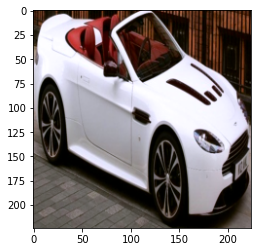

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Loaded model from epoch 22

0/2503
1/2503
2/2503
3/2503
4/2503
5/2503
6/2503
7/2503
8/2503
9/2503
10/2503
11/2503
12/2503
13/2503
14/2503
15/2503
16/2503
17/2503
18/2503
19/2503
20/2503
21/2503
22/2503
23/2503
24/2503
25/2503
26/2503
27/2503
28/2503
29/2503
30/2503
31/2503
32/2503
33/2503
34/2503
35/2503
36/2503
37/2503
38/2503
39/2503
40/2503
41/2503
42/2503
43/2503
44/2503
45/2503
46/2503
47/2503
48/2503
49/2503
50/2503
51/2503
52/2503
53/2503
54/2503
55/2503
56/2503
57/2503
58/2503
59/2503
60/2503
61/2503
62/2503
63/2503
64/2503
65/2503
66/2503
67/2503
68/2503
69/2503
70/2503
71/2503
72/2503
73/2503
74/2503
75/2503
76/2503
77/2503
78/2503
79/2503
80/2503
81/2503
82/2503
83/2503
84/2503
85/2503
86/2503
87/2503
88/2503
89/2503
90/2503
91/2503
92/2503
93/2503
94/2503
95/2503
96/2503
97/2503
98/2503
99/2503
100/2503
101/2503
102/2503
103/2503
104/2503
105/2503
106/2503
107/2503
108/2503
109/2503
110/2503
111/2503
112/2503
113/2503
114/2503
115/2503
116/2503
117/2503
118/2503
119/2503
1

In [13]:
parser = argparse.ArgumentParser(description='Testing script for Car Model classification')

# testing arg
parser.add_argument('--path', default=None, required=True,
                    help='path to model to be tested')
parser.add_argument('--image-path', default=None,
                    help='path to image to be tested')
parser.add_argument('--top-error', default=False, action='store_true',
                    help='compute top1 and top5 errors')

args = parser.parse_args(args=['--path', model_path,
                              #  '--image-path', 'data_modified/train/tesla_model_s_sedan_2012/015175.jpg'])
                              '--top-error'])

main(args)

In [14]:
# tensorboard_path = os.path.join(model_path, 'runs')

# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# %tensorboard --logdir tensorboard_path